# Household Power Consumption
## Análise não-supervisionada para identificar comportamentos de clientes a partir de consumo de energia
### Especificação

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

Você deve executar as seguintes tarefas:
    
1- Tratar os valores ausentes nos dados.

2- Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.

3- Encontrar o melhor valor de K para esse conjunto de dados.

4- Criar o modelo K-Means usando o valor de K encontrado no item 3.

5- Criar um Meshgrid para visualização de todos os clusters.

6- Visualizar os centróides.

7- Calcular o Silhoutte Score.

8 - Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

Dica: Para o item 8, considere a amostra criada no item 2.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [2]:
# Carregando os dados
dataset = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

## Data Undestanding & Data Wrangling

### Tratar os valores ausentes nos dados

In [3]:
# Visualizando estrutura dos dados
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Resumo do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


A base de dados contém + 2mi linhas com oito variaveis quantitativas e qualitativas. Avaliando as primeiras linhas armazenadas como 'object', é um indicativo de termos valores faltantes (missing/NA) ou registrados com outra nomenclatura.

In [5]:
# Somando total de linhas em branco encontradas para cada variável
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Das colunas categorizadas como 'object', notamos que apenas a variável 'Sub_metering_3' está com +25 mil linhas em branco, que serão tratadas posteriormente. Vamos analisar as demais criando uma tabela de contingência e vendo os valores armazenados.

In [6]:
# Verificando coluna 'Sub_metering_2' via tabela de contingência
display(dataset['Sub_metering_2'].value_counts().index)
display(dataset[dataset['Sub_metering_2'] == '?'])

Index(['0.000', '1.000', '2.000', '?', '3.000', '37.000', '4.000', '36.000',
       '38.000', '5.000', '35.000', '39.000', '28.000', '29.000', '27.000',
       '34.000', '18.000', '26.000', '6.000', '30.000', '23.000', '25.000',
       '19.000', '17.000', '24.000', '21.000', '22.000', '20.000', '31.000',
       '32.000', '33.000', '16.000', '40.000', '7.000', '72.000', '73.000',
       '15.000', '71.000', '14.000', '74.000', '8.000', '9.000', '10.000',
       '13.000', '11.000', '12.000', '70.000', '41.000', '75.000', '42.000',
       '69.000', '67.000', '68.000', '64.000', '63.000', '66.000', '76.000',
       '65.000', '62.000', '43.000', '60.000', '57.000', '61.000', '59.000',
       '44.000', '56.000', '46.000', '55.000', '54.000', '58.000', '48.000',
       '51.000', '52.000', '53.000', '47.000', '45.000', '49.000', '50.000',
       '77.000', '79.000', '78.000', '80.000'],
      dtype='object')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,?,?,?,?,?,?,NaN
1990186,28/9/2010,19:10:00,?,?,?,?,?,?,NaN
1990187,28/9/2010,19:11:00,?,?,?,?,?,?,NaN
1990188,28/9/2010,19:12:00,?,?,?,?,?,?,NaN


Note que encontramos registros preenchidos com '?', denominando informação faltante. É notável que todas as variáveis das linhas em questão estão com valores faltantes, portanto removeremos estas observações da análise.

In [7]:
# Check para verificar se temos a mesma quantidade de valores missing para cada coluna
for col in dataset.columns.tolist()[2:]:
    print(col + ': ' + str(len(dataset[dataset[col] == '?'])) + ' missing values.')

Global_active_power: 25979 missing values.
Global_reactive_power: 25979 missing values.
Voltage: 25979 missing values.
Global_intensity: 25979 missing values.
Sub_metering_1: 25979 missing values.
Sub_metering_2: 25979 missing values.
Sub_metering_3: 0 missing values.


In [8]:
# Tratando dados missing
dataset['Sub_metering_3'] = dataset['Sub_metering_3'].fillna('?')
dataset_clean = dataset[~(dataset['Sub_metering_3'] == '?')]
dataset_clean

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0


In [9]:
# Check de valores missing no novo dataset
for col in dataset_clean.columns.tolist()[2:]:
    print(col + ': ' + str(len(dataset_clean[dataset_clean[col] == '?'])) + ' missing values.')

Global_active_power: 0 missing values.
Global_reactive_power: 0 missing values.
Voltage: 0 missing values.
Global_intensity: 0 missing values.
Sub_metering_1: 0 missing values.
Sub_metering_2: 0 missing values.
Sub_metering_3: 0 missing values.


## Model Development

### Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means

In [10]:
# Removeremos os indicadores de data e hora para a criação do modelo não supervisionado (K-Means)
dataset_model = dataset_clean.iloc[:, 2:]
display(dataset_model)

# Separando dados em treino e teste
amostra1, amostra2 = train_test_split(dataset_model, train_size = 0.01)
display(len(amostra1))
display(len(amostra2))

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17
1,5.360,0.436,233.630,23.000,0.000,1.000,16
2,5.374,0.498,233.290,23.000,0.000,2.000,17
3,5.388,0.502,233.740,23.000,0.000,1.000,17
4,3.666,0.528,235.680,15.800,0.000,1.000,17
...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.430,4.000,0.000,0.000,0
2075255,0.944,0.000,240.000,4.000,0.000,0.000,0
2075256,0.938,0.000,239.820,3.800,0.000,0.000,0
2075257,0.934,0.000,239.700,3.800,0.000,0.000,0


20492

2028788

Valores estão em escala diferente, portanto aplicaremos redução de dimensionalidade usando PCA antes de treinar o modelo com K-Means.

In [11]:
# Treinando modelo PCA
pca = PCA(n_components = 2).fit_transform(amostra1)

### Encontrar o melhor valor de K para esse conjunto de dados

In [12]:
# Treinando modelo K-Means em range pré-estabelecido + fit com PCA
K_clusters = [n for n in range(2, 15)]
K_results = [KMeans(n_clusters = K).fit(pca) for K in K_clusters]

# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in K_results]

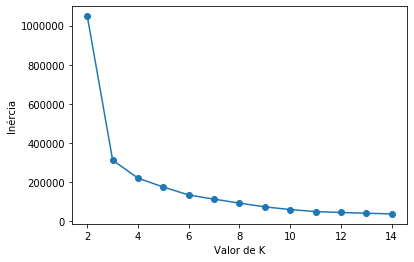

In [13]:
# Inércia é a soma das distâncias das amostras para o seu centro de agrupamento mais próximo.

# Lista para consolidar métricas
valores_metrica = []

# Loop por diferentes modelos com diferentes valores de K
for K in range(len(K_clusters)):
    modelo = K_results[K]
    valores_metrica.append(modelo.inertia_)

plt.plot(K_clusters, valores_metrica, 'o-')
plt.xlabel("Valor de K")
plt.ylabel("Inércia")
plt.show()

A partir do gráfico acima, vemos que temos uma mudança de valor significativo na inércia até o oitavo cluster (k = 8) e em seguida a significância é pífea, portanto utilizaremos oito clusters para determinação do nosso modelo final.

In [14]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
centroids = [X.cluster_centers_ for X in K_results]

k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

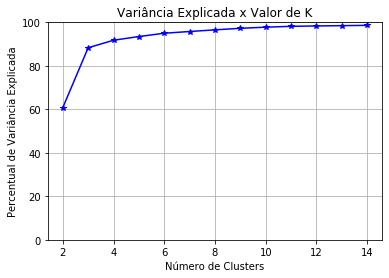

In [15]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K_clusters, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

Em contrapartida ao gráfico de inércia, um maior nível de variância simboliza que aquela quantidade de clusters (K) explica a variância dos dados ali apresentados. Isso confirma a afirmação de que oito clusters pode ser um número ideal de clusters para elaboração do modelo final.

### Criar o modelo K-Means usando o valor de K encontrado no item 3

In [16]:
modelo_v1 = KMeans(n_clusters = 8).fit(pca)
modelo_v1

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.801167165503372

Na métrica acima, recebemos um valor entre o range [-1, 1], sendo:
- -1 uma associação incorreta dos clusters;
- 0 uma proximidade muito alta intra-clusters (o que representa que os 'vizinhos' estão muito próximos entre um e outro)
- 1 uma distância (euclidiana) intra-cluster alta, que é o ideal.
Pelas categorizações acima, temos um ótimo silhouette score para este primeiro modelo.

## Model Evaluation (Data Viz)

### Criar um Meshgrid para visualização de todos os clusters.

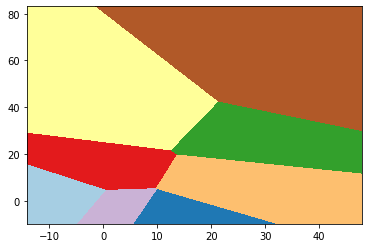

In [18]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

### Visualizar os centróides

In [19]:
# Verificando estrutura PCA com dois componentes
pca

array([[-6.74775123,  0.07461096],
       [-7.21369605,  0.73699228],
       [-7.13256006,  0.98744828],
       ...,
       [-2.49740631,  3.55281408],
       [10.43839624, -6.48720186],
       [-6.95563081,  1.10387889]])

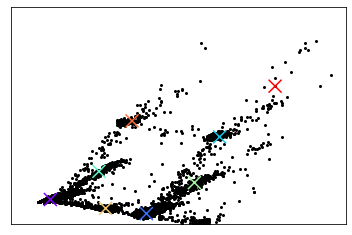

In [20]:
# Plot dos centróides
import matplotlib.cm as cm

centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
labels = modelo_v1.labels_

x = np.arange(8)
ys = [i+x+(i*x)**2 for i in range(8)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = colors, zorder = 8)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.show()

### Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média)

In [21]:
# Recriando DataFrame com classificações criadas via KMeans
dataset_cluster = pd.DataFrame(amostra1, columns = dataset_model.columns.tolist())
dataset_cluster['Global_active_power'] = pd.to_numeric(dataset_cluster['Global_active_power'])
dataset_cluster['cluster'] = modelo_v1.labels_
dataset_cluster.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
1442409,0.264,0.122,241.310,1.200,0.000,0.000,1,0
506220,0.548,0.000,242.260,2.400,0.000,0.000,0,0
651997,0.360,0.074,239.790,1.400,0.000,1.000,0,0
395770,0.210,0.108,240.700,1.000,0.000,0.000,0,0
1558742,0.304,0.000,245.030,1.200,0.000,0.000,0,0


In [22]:
# Verificando média de consumo de energia por cluster ('Global_active_power')
dataset_cluster[['cluster', 'Global_active_power']].groupby('cluster').mean()

,Global_active_power
cluster,
0,0.505280
1,1.826603
2,4.419481
3,2.573878
4,3.902421
5,1.067935
6,3.370955
7,6.669116


### Fim